In [1]:
from imports import plt, np, pd, rfft, rfftfreq, irfft, lombscargle, TimeSeriesSplit, tf
import data_processing

2024-03-17 00:59:06.920709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 00:59:06.920750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 00:59:06.921508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 00:59:06.926530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 00:59:07.596433: W tensorflow/compiler/tf2

In [2]:
sunspots = data_processing.read_data()
sunspots

,Greg_Year,Month,Dec_Year,N_total_sunspots_smoothed,Montly_mean_sunspot_number_std,N_obs,Marker
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3297,2023,10,2023.790,99.4,16.0,958,0
3298,2023,11,2023.873,105.4,16.7,809,0
3299,2023,12,2023.958,114.2,17.9,619,0
3300,2024,1,2024.042,123.0,18.7,783,0


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of sunspots'),
 Text(0.5, 1.0, 'Monthly averaged number of sunspots')]

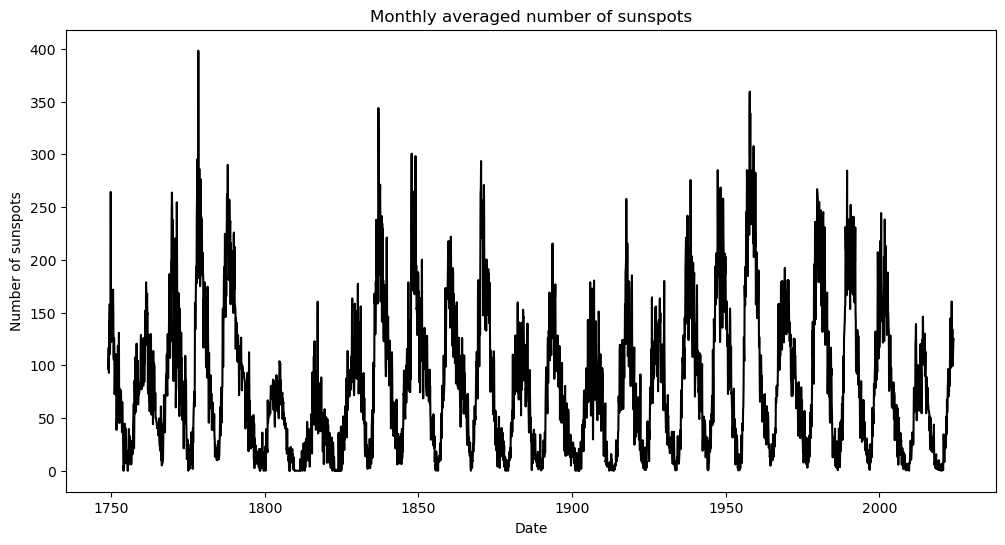

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'k-')
ax.set(
    xlabel='Date',
    ylabel='Number of sunspots',
    title='Monthly averaged number of sunspots',
)

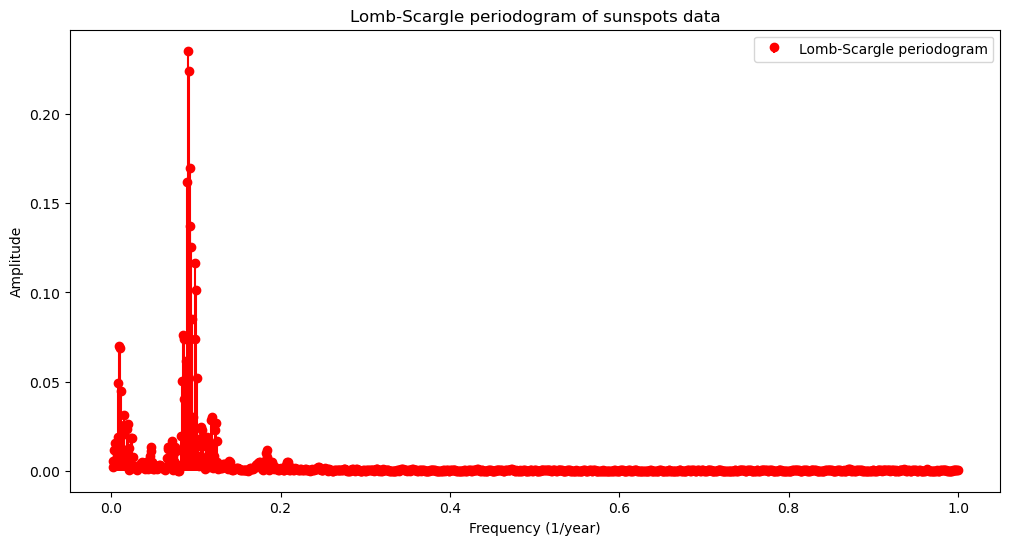

In [4]:
freq_periodogram = np.linspace(0.01, 2*np.pi, 1000)
periodogram = lombscargle(sunspots['Dec_Year']-sunspots['Dec_Year'].iloc[0], 
                    sunspots['N_total_sunspots_smoothed']-np.mean(sunspots['N_total_sunspots_smoothed']), 
                    freq_periodogram, normalize=True)

fig, ax = plt.subplots(figsize=(12, 6))

ax.stem(freq_periodogram/(2*np.pi), periodogram, 'r', label='Lomb-Scargle periodogram', basefmt="none")
ax.set(
    xlabel='Frequency (1/year)',
    ylabel='Amplitude',
    title='Lomb-Scargle periodogram of sunspots data',
)
plt.legend()

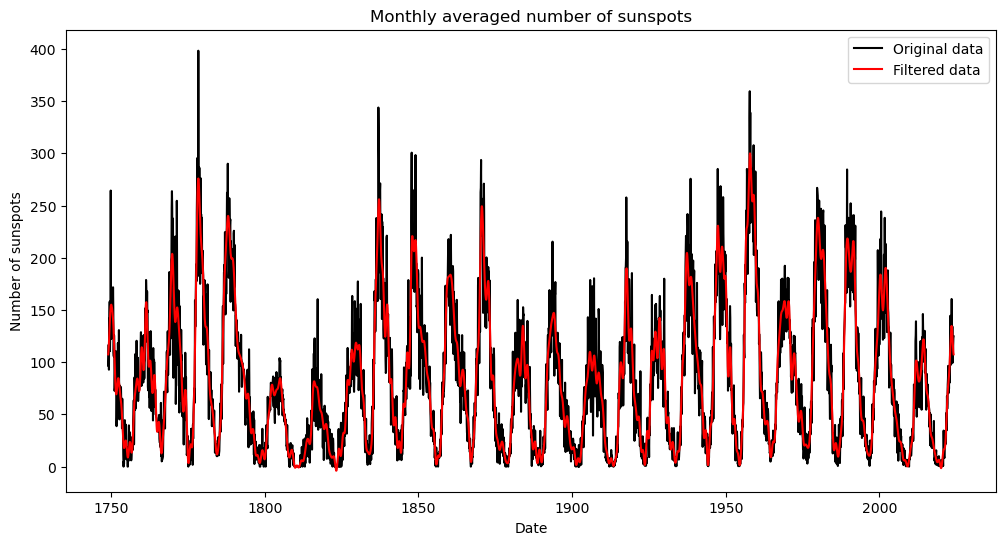

In [5]:
ft = rfft(sunspots["N_total_sunspots_smoothed"].to_numpy())
frequencies = rfftfreq(len(sunspots["N_total_sunspots_smoothed"]), d=sunspots["Dec_Year"].diff().mean())

ft[frequencies>0.8] = 0
sunspots_filtered = irfft(ft)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'k-', label='Original data')
ax.plot(sunspots['Dec_Year'], sunspots_filtered, 'r-', label='Filtered data')
ax.set(
    xlabel='Date',
    ylabel='Number of sunspots',
    title='Monthly averaged number of sunspots',
)
plt.legend()

In [6]:
sunspots['N_total_sunspots_smoothed'] = sunspots_filtered

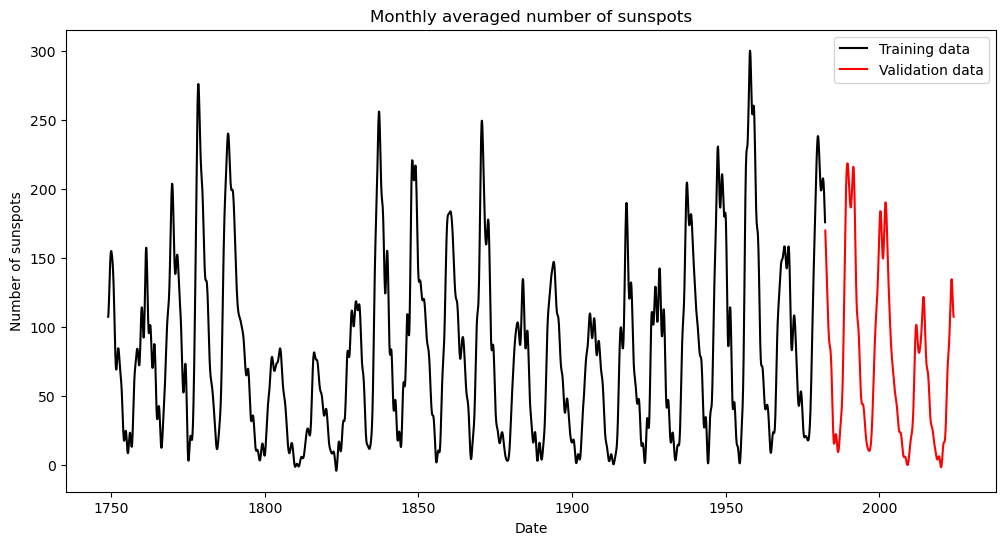

In [7]:
split_time = 2800
time_train = sunspots['Dec_Year'][:split_time]
x_train = sunspots['N_total_sunspots_smoothed'][:split_time]
time_valid = sunspots['Dec_Year'][split_time:]
x_valid = sunspots['N_total_sunspots_smoothed'][split_time:]

time_train = time_train.to_numpy()
x_train = x_train.to_numpy()
time_valid = time_valid.to_numpy()
x_valid = x_valid.to_numpy()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(time_train, x_train, 'k-', label='Training data')
ax.plot(time_valid, x_valid, 'r-', label='Validation data')
ax.set(
    xlabel='Date',
    ylabel='Number of sunspots',
    title='Monthly averaged number of sunspots',
)
plt.legend()

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size = 64
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-03-17 00:59:09.136818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 00:59:09.151910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 00:59:09.151961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 00:59:09.154813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 00:59:09.154900: I external/local_xla/xla/stream_executor

In [9]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    metrics=["mae"]
)

history = model.fit(train_set, epochs=5)

2024-03-17 00:59:09.634621: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/5


2024-03-17 00:59:12.212804: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-17 00:59:12.302691: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-17 00:59:13.046136: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f644db18880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-17 00:59:13.046175: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-03-17 00:59:13.050365: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710633553.117157  320055 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 [==============================] - 5s 14ms/step - loss: 28.4518 - mae: 28.9404
Epoch 2/5
86/86 [==============================] - 1s 12ms/step - loss: 6.3232 - mae: 6.7961
Epoch 3/5
86/86 [==============================] - 1s 12ms/step - loss: 5.2672 - mae: 5.7383
Epoch 4/5
86/86 [==============================] - 1s 12ms/step - loss: 3.6995 - mae: 4.1602
Epoch 5/5
86/86 [==============================] - 1s 12ms/step - loss: 3.1171 - mae: 3.5751


14/14 [==============================] - 0s 17ms/step


2024-03-17 01:18:52.801191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11891721059690962114


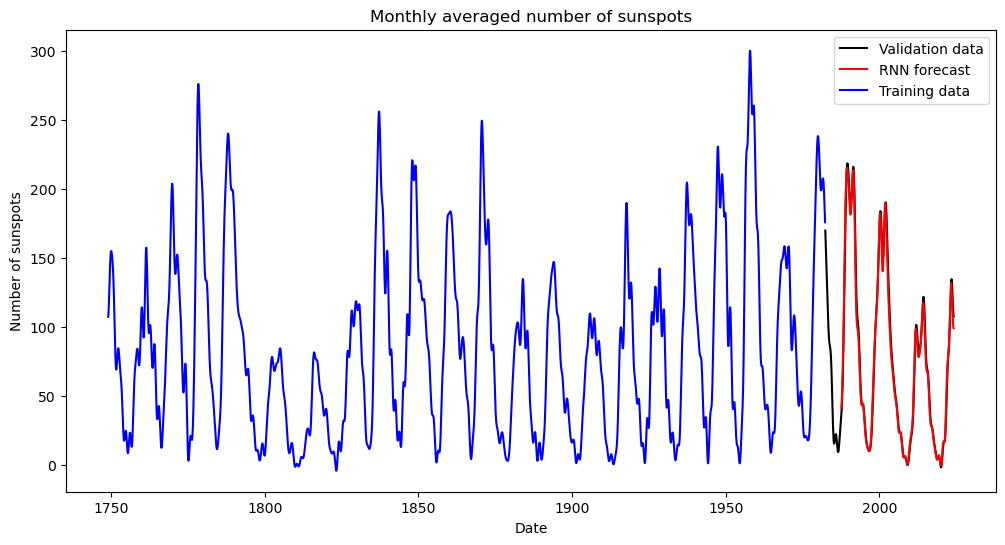

In [34]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, x_valid[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[:, 0]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(time_valid, x_valid, 'k-', label='Validation data')
ax.plot(time_valid[window_size-1:], rnn_forecast, 'r-', label='RNN forecast')
ax.plot(time_train, x_train, 'b-', label='Training data')
ax.set(
    xlabel='Date',
    ylabel='Number of sunspots',
    title='Monthly averaged number of sunspots',
)
plt.legend()